In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/DS:Deep Learning in Python/facial expression recognition')

i: 0 j: 0 nb 391 cost: 3.6622663 error_rate: 0.812
i: 0 j: 20 nb 391 cost: 3.7052383 error_rate: 0.772
i: 0 j: 40 nb 391 cost: 3.5800502 error_rate: 0.757
i: 0 j: 60 nb 391 cost: 3.5566 error_rate: 0.78
i: 0 j: 80 nb 391 cost: 3.5332057 error_rate: 0.761
i: 0 j: 100 nb 391 cost: 3.4859667 error_rate: 0.721
i: 0 j: 120 nb 391 cost: 3.4368176 error_rate: 0.759
i: 0 j: 140 nb 391 cost: 3.3942747 error_rate: 0.778
i: 0 j: 160 nb 391 cost: 3.3435793 error_rate: 0.759
i: 0 j: 180 nb 391 cost: 3.2845418 error_rate: 0.725
i: 0 j: 200 nb 391 cost: 3.2621527 error_rate: 0.74
i: 0 j: 220 nb 391 cost: 3.1325383 error_rate: 0.676
i: 0 j: 240 nb 391 cost: 3.2084002 error_rate: 0.761
i: 0 j: 260 nb 391 cost: 3.1021645 error_rate: 0.717
i: 0 j: 280 nb 391 cost: 3.0583944 error_rate: 0.695
i: 0 j: 300 nb 391 cost: 3.0086856 error_rate: 0.7
i: 0 j: 320 nb 391 cost: 2.9103444 error_rate: 0.691
i: 0 j: 340 nb 391 cost: 2.8876457 error_rate: 0.695
i: 0 j: 360 nb 391 cost: 2.8185356 error_rate: 0.724
i: 0 j

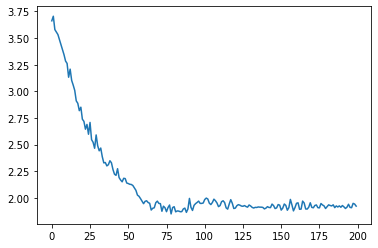

In [6]:
from __future__ import print_function, division
from builtins import range

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from util import getData, getBinaryData, y2indicator, error_rate, init_weight_and_bias
from sklearn.utils import shuffle

class HiddenLayer(object):
    def __init__(self, M1, M2, an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W, b = init_weight_and_bias(M1, M2)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        self.params = [self.W, self.b]

    def forward(self, X):
        return tf.nn.relu(tf.matmul(X, self.W) + self.b)

class ANN(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes

    def fit(self, X, Y, Xvalid, Yvalid, learning_rate=1e-2, mu=0.99, decay=0.999, reg=1e-3, epochs=10, batch_sz = 100, show_fig=False):
        K = len(set(Y))

        #make a validation set
        X, Y = shuffle(X,Y)
        X = X.astype(np.float32)
        Y = y2indicator(Y).astype(np.float32)

        #for calculating error rate
        Yvalid_flat = Yvalid
        Yvalid = y2indicator(Yvalid).astype(np.float32)

        #initialize hidden layers
        N, D = X.shape

        self.hidden_layers = []
        M1 = D
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        W, b = init_weight_and_bias(M1, K)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))

        #collect params for later use
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params

        #setup TF functions and variables
        tfX = tf.placeholder(tf.float32, shape=(None, D), name='X')
        tfT = tf.placeholder(tf.float32, shape = (None, K), name='T')
        act = self.forward(tfX)

        rcost = reg*sum([tf.nn.l2_loss(p) for p in self.params])
        cost =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=act, labels=tfT)) + rcost
        prediction = self.predict(tfX)
        train_op = tf.train.RMSPropOptimizer(learning_rate, decay=decay, momentum=mu).minimize(cost)
        
        n_batches = N // batch_sz
        costs = []
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                X, Y = shuffle(X, Y)
                for j in range(n_batches):
                    Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                    Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                    session.run(train_op, feed_dict = {tfX: Xbatch, tfT:Ybatch})

                    if j%20 == 0:
                        c = session.run(cost, feed_dict={tfX:Xvalid, tfT:Yvalid})
                        costs.append(c)
                        p = session.run(prediction, feed_dict={tfX: Xvalid, tfT: Yvalid})
                        e = error_rate(Yvalid_flat, p)
                        print("i:", i, "j:", j, "nb", n_batches, "cost:", c, "error_rate:",e)     


            if show_fig:
                plt.plot(costs)
                plt.show()

    def forward(self, X):
        Z = X
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return tf.matmul(Z, self.W) + self.b

    def predict(self, X):
        act = self.forward(X)
        return tf.argmax(act, 1)

def main():
    Xtrain, Ytrain, Xvalid, Yvalid = getData()
    model = ANN([2000,1000, 500])
    model.fit(Xtrain, Ytrain, Xvalid, Yvalid, show_fig=True)


if __name__=='__main__':
    main()
